## Lab | Random Forests

For this lab, you will be using the CSV files provided in the `files_for_lab` folder.  These are cleaned versions of the learningSet data from the Case Study 'Healthcare for All'.

### Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data.
- Use Feature Selections that you have learned in class to decide if you want to use all of the features (PCA, etc)
- Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?

Feedback from Erin

put together data to create X and y

Target B as y for random forests | predict who will donate and who will not

handling imbalance, specifically run the random forest, eliminate features that dont matter (feature extraction of maybe 25 best features), run random forest again and see how much better it preforms


Target D as y for regression | where target b is 1 

take people who will not donate

### Imports

In [1]:
# general libraries

import pandas as pd
import numpy as np

In [2]:
# dataframes

categorical = pd.read_csv('files_for_lab/categorical.csv')
numerical = pd.read_csv('files_for_lab/numerical.csv')
targets = pd.read_csv('files_for_lab/target.csv')

In [3]:
donors_df = pd.concat([numerical, categorical, targets], axis = 1)

### How would you plant a forest? Tree by tree of course!

In [4]:
# readying the seeds (defining X and y)

X = donors_df.drop(['TARGET_B'], axis = 1)
y = donors_df['TARGET_B']

In [44]:
# getting out my gardening tools (further imports)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [6]:
# Enough gardening puns...Splitting the same unchanged DF I just concattenated...

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

In [7]:
# onehot and concat back together

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

In [8]:
# train/test split before upsampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# for upsampling we need to temporarily concat X_train and y_train

trainset = pd.concat([X_train, y_train], axis=1)

In [10]:
# cat split ahead of upsampling

category_0 = trainset[trainset['TARGET_B'] == 0]
category_1 = trainset[trainset['TARGET_B'] == 1]

In [11]:
print(category_0.shape)
category_1.shape

(72486, 356)


(3843, 356)

In [12]:
# upsampling

category_1_oversampled = resample(category_1, 
                                  replace=True,
                                  n_samples = len(category_0))

In [13]:
category_1_oversampled.shape

(72486, 356)

In [14]:
# merging upsampled trainset

trainset_new = pd.concat([category_0, category_1_oversampled], axis = 0)
trainset_new = trainset_new.sample(frac =1) #randomize the rows

In [15]:
# X/y trainsplit

X_train = trainset_new.drop(['TARGET_B'], axis=1)
y_train = trainset_new['TARGET_B']

In [16]:
print(X_train.shape)

(144972, 355)


In [17]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']

# Now we can remove the column target d from the set of features
X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [18]:
y_test

58053    0
9484     0
13395    0
1466     0
2076     0
        ..
94255    0
26449    0
1969     0
48574    0
73270    0
Name: TARGET_B, Length: 19083, dtype: int64

In [19]:
y_test_regression

58053    0.0
9484     0.0
13395    0.0
1466     0.0
2076     0.0
        ... 
94255    0.0
26449    0.0
1969     0.0
48574    0.0
73270    0.0
Name: TARGET_D, Length: 19083, dtype: float64

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.6222511933338851
0.6017397683802337


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[10930,  7153],
       [  447,   553]])

In [31]:
%%time
# For cross validation
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.4)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))


0.6202439318125699
CPU times: user 2min 16s, sys: 4.46 s, total: 2min 21s
Wall time: 2min 23s


In [32]:
cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')

array([0.62215864, 0.62170534, 0.6196343 , 0.61474924, 0.61789853])

In [33]:
cross_val_scores

array([0.61449855, 0.62270658, 0.61867973, 0.63095813, 0.61598952,
       0.62461199, 0.61950748, 0.61557564, 0.61592054, 0.62399117])

In [41]:
select = SelectFromModel(clf)
select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=5, max_samples=0.4,
                                                 min_samples_leaf=20,
                                                 min_samples_split=20))

In [43]:
select.feature_importances_

AttributeError: 'SelectFromModel' object has no attribute 'feature_importances_'

In [42]:
print(X_train.columns[(select.get_support())])

Index([         'AGE',      'WEALTH2',         'ETH2',          'HV1',
                'HV2',         'HHD7',         'HHD9',        'ETHC3',
              'ETHC4',        'ETHC5',         'HVP1',         'HVP2',
               'HVP3',         'HVP4',         'HVP5',          'RP1',
                'RP2',          'RP3',          'DMA',          'IC1',
                'IC3',          'IC4',          'IC5',         'IC20',
              'HHAS3',          'EC2',          'EC7',        'POBC2',
           'CARDPROM',      'NUMPROM',     'CARDPM12',     'NUMPRM12',
           'RAMNTALL',     'NGIFTALL',     'CARDGIFT',     'MINRAMNT',
           'MAXRAMNT',     'LASTGIFT',      'TIMELAG',      'AVGGIFT',
           'CONTROLN',       'RFA_2F',    'ODATEW_YR',       'DOB_YR',
        'MAXRDATE_YR',  'LASTDATE_YR',  'LASTDATE_MM', 'FIRSTDATE_YR',
                   14,             15,             16],
      dtype='object')


In [39]:
from sklearn.feature_selection import SelectKBest, chi2
select = SelectKBest(score_func=chi2, k=3)
select.fit_transform(X,y)

NameError: name 'x' is not defined

TypeError: 'value' must be an instance of str or bytes, not a int

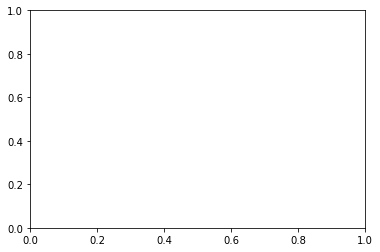

In [48]:
f_i = list(zip(X,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

## Lab | Final regression model in "Health Care for All" Case

### Instructions

At this point, we have created a model to predict who will make a donation and who won't. But, what about the ammount of money that each person will give?
In this lab, subset those that made a donation and use that subset to create a model to predict how much money will they give.

Evaluate the result of your model and estimate how much better the result are for the bussiness in comparison with the naive scenario we discuss on Monday.